# Homework 7 Template

Rixin Li & G . Besla

look for "****"

In [1]:
# import necessary modules
# numpy provides powerful multi-dimensional arrays to hold and manipulate data
import numpy as np
# matplotlib provides powerful functions for plotting figures
import matplotlib.pyplot as plt
# astropy provides unit system and constants for astronomical calculations
import astropy.units as u
import astropy.constants as const
# import Latex module so we can display the results with symbols
from IPython.display import Latex
# import plotting modules
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# **** import CenterOfMass to determine the COM pos/vel of M33
from CenterOfMass import CenterOfMass

# **** import the GalaxyMass to determine the mass of M31 for each component
from GalaxyMass import ComponentMass

# M33AnalyticOrbit

In [38]:
class M33AnalyticOrbit:
    """ Calculate the analytical orbit of M33 around M31 """
    
    def __init__(self, filename): # **** add inputs
        """ 
        # Initialize the instance of this Class with the following properties:
        # filename : filename for the file in which to store in the integrated orbit """

        ### get the gravitational constant (the value is 4.498502151575286e-06)
        self.G = const.G.to(u.kpc**3/u.Msun/u.Gyr**2).value
        ### **** store the output file name
        self.filename = filename
        
        ### get the current pos/vel of M33 
        # **** create an instance of the  CenterOfMass class for M33 
        M33COM = CenterOfMass("M33_000.txt",2) 
        # **** store the position VECTOR of the M33 COM (.value to get rid of units)
        M33_COM_P = M33COM.COM_P(0.1)
        
        # **** store the velocity VECTOR of the M33 COM (.value to get rid of units)
        M33_COM_V = M33COM.COM_V(M33_COM_P[0],M33_COM_P[1],M33_COM_P[2])
        
        ### get the current pos/vel of M31 
        # **** create an instance of the  CenterOfMass class for M31 
        M31COM = CenterOfMass("M31_000.txt",2) 
        # **** store the position VECTOR of the M31 COM (.value to get rid of units)
        M31_COM_P = M31COM.COM_P(0.1)
        # **** store the velocity VECTOR of the M31 COM (.value to get rid of units)
        M31_COM_V = M31COM.COM_V(M31_COM_P[0],M31_COM_P[1],M31_COM_P[2])
        
        ### store the DIFFERENCE between the vectors posM33 - posM31
        # **** create two VECTORs self.r0 and self.v0 and have them equal the
        # relative position and velocity VECTORS of M33
        self.r0 = M33_COM_P.value - M31_COM_P.value
        self.v0 = M33_COM_V.value - M33_COM_V.value
        
        ### get the mass of each component in M31 
        ### disk
        # **** self.rdisk = scale length (no units)
        self.rdisk = 5
        # **** self.Mdisk set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mdisk = ComponentMass("M31_000.txt",2)*1e12
        ### bulge
        # **** self.rbulge = set scale length (no units)
        self.rbulge = 1
        # **** self.Mbulge  set with ComponentMass function. Remember to *1e12 to get the right units Use the right ptype
        self.Mbulge = ComponentMass("M31_000.txt",3)*1e12
        # Halo
        # **** self.rhalo = set scale length from HW5 (no units)
        self.rhalo = 62
        # **** self.Mhalo set with ComponentMass function. Remember to *1e12 to get the right units. Use the right ptype
        self.Mhalo = ComponentMass("M31_000.txt",1)*1e12

    
    
    def HernquistAccel(self,M,r_a,r_v): # it is easiest if you take as an input the position VECTOR 
        """  
        # Function to compute the Gravitational Acceleration Vector of M31
        # This function wil be used for both Halo and Bulge of M31
        # Inputs:
        #        M is the Total Halo and Bulge Mass 
        #        r_a is the corresponding Scale Length 
        #        r_v are the positions of M31 Halo and Bulge in vector form
        # Returns:
        #        Acceleration vector from a Hernquist Potential """
        
        ### **** Store the magnitude of the position vector
        
        r = np.sqrt(r_v[0]**2 + r_v[1]**2 + r_v[2]**2)
        a = (-1)*(self.G)*(M)*(r_v)
        b = (r)*((r_a + r)**2)
        ### *** Store the Acceleration
        #Hern = -(self.G)*(M)/(r(r_a + r)**2)*(r) #follow the formula in the HW instructions
        Hern = a/b
        # NOTE: we want an acceleration VECTOR so you need to make sure that in the Hernquist equation you 
        # use  -G*M/(rmag *(ra + rmag)**2) * r --> where the last r is a VECTOR 
        
        return Hern
    
    
    
    def MiyamotoNagaiAccel(self,M,rd,r):# it is easiest if you take as an input a position VECTOR  r 
        """ 
        Function to compute Disk Acceleration Vector of M31
        # Inputs:
        #        M is the Disk Mass 
        #        rd is the corresponding Scale Length   
        #        r is the positions of M31 Disk in vector form
        # Returns:
        #        Acceleration vector from a Miyamoto-Nagai Profile """
        
        ### Acceleration **** follow the formula in the HW instructions
        zd = self.rdisk/5.0
        R = np.sqrt(r[0]**2 + r[1]**2)
        B = rd + np.sqrt(r[2]**2 + zd**2)
        # ZSTUFF are the terms associated with the z direction                 
        ZSTUFF = B/np.sqrt(r[2]**2 + zd**2)
        # Miyamoto-Nagai Profile
        MN_profile = -(self.G)*M/(R**2 + B**2)**1.5
        # Acceleration vector                  
        Acc = MN_profile*r*np.array([1,1,ZSTUFF])
    
        
                
        
        # AGAIN note that we want a VECTOR to be returned  (see Hernquist instructions)
        # this can be tricky given that the z component is different than in the x or y directions. 
        # we can deal with this by multiplying the whole thing by an extra array that accounts for the 
        # differences in the z direction:
        # multiply the whole thing by :   np.array([1,1,ZSTUFF]) 
        # where ZSTUFF are the terms associated with the z direction       
       
        return Acc
        # the np.array allows for a different value for the z component of the acceleration
     
    
    def M31Accel(self,r): # input should include the position vector, r (in the format of an array)
        """
        Function commputes the sum of all acceleration
        Inputs: 
               r is the 3D position vector 
        Returns: 
               The 3D total acceleration vector of M31
        """
        
        ### Call the previous functions for the halo, bulge and disk
        # **** these functions will take as inputs variable we defined in the initialization of the class like 
        # self.rdisk etc. 
        # Acceleration vector of M31 Bulge
        HernBulge = self.HernquistAccel(self.Mbulge,self.rbulge,r)  
        # Acceleration vector of M31 Halo
        HernHalo = self.HernquistAccel(self.Mhalo,self.rhalo,r)
        # Acceleration vector of M31 Disk
        MN = self.MiyamotoNagaiAccel(self.Mdisk,self.rdisk,r)
        
                         
            # return the SUM of the output of the acceleration functions - this will return a VECTOR 
        return HernBulge + HernHalo + MN
    
    
    
    def LeapFrog(self,dt,r,v): # take as input r and v, which are VECTORS. Assume it is ONE vector at a time
        """
        Function computes 
        Inputs:
                dt is the time interval for integration
                r is the position vector for M33 COM relative to M31
                v is the velocity vector for M33 relative to M31
        Returns: 
                rnew is the new position vector
                vnew is the new velocity vector
        """              
        # predict the position at the next half timestep
        rhalf = r + (v)*(dt)*(0.5)
        
        # compute the velocity at the next timestep
        # calling M31 Acceleration function
        Acc_M31 = self.M31Accel(rhalf)
        vnew = v + Acc_M31*dt
        
        # compute the position at the next timestep
        rnew = r + (v+vnew)*(dt)*(0.5)
        
        return rnew, vnew # **** return the new position and velcoity vectors
    
    
    def OrbitIntegration(self, t0, dt, tmax):
        """
        Function Integrates the orbit using LeapFrog function
        Inputs:
                t0 is the starting time
                dt is the time interval
                tmax is the final time
        """

        # initialize the time to the input starting time
        t = t0
        
        # initialize an empty array of size :  rows int(tmax/dt)+2  , columns 7
        orbit = np.zeros([int(tmax/dt)+2,7])
        
        # initialize the first row of the orbit
        orbit[0] = t0, *tuple(self.r0), *tuple(self.v0)
        # this above is equivalent to 
        # orbit[0] = t0, self.r0[0], self.r0[1], self.r0[2], self.v0[0], self.v0[1], self.v0[2]
        
        
        # initialize a counter for the orbit.  
        i = 1 # since we already set the 0th values, we start the counter at 1
        #r, v =self.r0, self.v0
        # start the integration (advancing in time steps and computing LeapFrog at each step)
        while (t<tmax):  # as long as t has not exceeded the maximal time 
            
            # **** advance the time by one timestep, dt
            t = t + dt
           
            # **** store the new time in the first element of the ith row
            orbit[i,0] = t
            
            # ***** advance the position and velocity using the LeapFrog scheme
            #r, v =self.r0, self.v0
            rnew, vnew = self.LeapFrog(dt,r,v)
            # remember that LeapFrog returns a position vector and a velocity vector  
            # as an example, if a function returns three vectors you would call the function and store 
            # the variable like:     a,b,c = function(input)
         
    
            # ****  store the new position vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i,1] = rnew[0] 
            orbit[i,2] = rnew[1]
            orbit[i,3] = rnew[2]
            # TIP:  if you want columns 5-7 of the Nth row of an array called A, you would write : 
            # A[n, 5:8] 
            # where the syntax is row n, start at column 5 and end BEFORE column 8
            
            
            # ****  store the new velocity vector into the columns with indexes 1,2,3 of the ith row of orbit
            orbit[i,4] = vnew[0]
            orbit[i,5] = vnew[1]
            orbit[i,6] = vnew[2]
            
            # **** update counter i , where i is keeping track of the number of rows (i.e. the number of time steps)
            i = i + 1
            r, v = rnew, vnew
        
        
        # write the data to a file
        np.savetxt(self.filename, orbit, fmt = "%11.3f"*7, comments='#', 
                    header="{:>10s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}{:>11s}"\
                    .format('t', 'x', 'y', 'z', 'vx', 'vy', 'vz'))
        
        # there is no return function
        

In [39]:
M31_Data = M33AnalyticOrbit("M33Orbit.txt")
M31_Orbit = M31_Data.OrbitIntegration(0, 0.1, 10)

UnboundLocalError: local variable 'r' referenced before assignment

In [31]:
# Read in the data files 
# headers:  t, x, y, z, vx, vy, vz
# using np.genfromtxt

#MWOrbit = np.genfromtxt('Orbit_MW.txt',dtype=None,names=True) 
M31Orbit = np.genfromtxt('Orbit_M31.txt',dtype=None,names=True) 
M33Orbit = np.genfromtxt('Orbit_M33.txt',dtype=None,names=True)
M33_A_Orbit = np.genfromtxt('M33Orbit.txt',dtype=None,names=True) 

In [32]:
# function to compute the magnitude of the difference between two vectors 
# You can use this function to return both the relative position and relative velocity for two 
# galaxies over the entire orbit  
def relative_mag(orbit1, orbit2): 
    # Input: 3D vector 1 , 3D vector 2
    # returns the magnitude of the relative position and velocities
    pos =  np.sqrt( (orbit1['x']-orbit2['x'])**2 + (orbit1['y']-orbit2['y'])**2 + (orbit1['z']-orbit2['z'])**2)
    vel =  np.sqrt( (orbit1['vx']-orbit2['vx'])**2 + (orbit1['vy']-orbit2['vy'])**2 + (orbit1['vz']-orbit2['vz'])**2)
    return pos,vel

In [33]:
def mag(orbit): 
    # Input: 3D vector 1 , 3D vector 2
    # returns the magnitude of the relative position and velocities
    pos =  np.sqrt( (orbit['x'])**2 + (orbit['y'])**2 + (orbit['z'])**2)
    vel =  np.sqrt( (orbit['vx'])**2 + (orbit['vy'])**2 + (orbit['vz'])**2)
    return pos,vel

In [34]:
# Determine the magnitude of the relative position and velocities 

# of MW and M31 (Analytic)
A_M33_M31_R, A_M33_M31_V = mag(M33_A_Orbit)

# of M33 and M31
M33_M31_R, M33_M31_V = relative_mag(M31Orbit, M33Orbit)

In [36]:
A_M33_M31_R

array([ 201.08279713,  200.38359982,  198.27735819,  194.74079629,
        189.73390621,  183.19389421,  175.03416226,  165.13700572,
        153.34087128,  139.41814419,  123.0447413 ,  103.73165886,
         80.66857629,   52.30297063,   14.32870221,    7.34162393,
         17.25090751,    4.50989767,   10.40809747,   16.90146432,
         62.98624289,  101.44472787,  135.96551507,  167.91524182,
        197.99696804,  226.63654679,  254.11511479,  280.63142605,
        306.3311447 ,  331.32861715,  355.71029424,  379.54791285,
        402.89972191,  425.81228163,  448.3280233 ,  470.48110872,
        492.30212766,  513.81583249,  535.04553887,  556.01131865,
        576.73122125,  597.22087971,  617.49369618,  637.56262996,
        657.44133747,  677.13759673,  696.66225874,  716.02499364,
        735.23144017,  754.29196412,  773.21084614,  791.99626443,
        810.65275347,  829.18643969,  847.60271297,  865.90585612,
        884.10075216,  902.19030323,  920.17966545,  938.07211

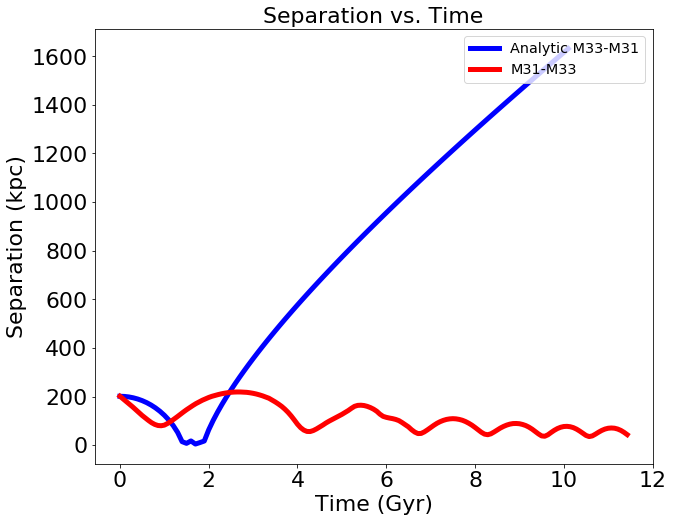

In [37]:
# Plot the Orbit of the galaxies 
#################################


fig, ax= plt.subplots(figsize=(10, 8))


# Plot the separtion of M33 and M31 (Analytic)
ax.plot(M33_A_Orbit['t'], A_M33_M31_R, color='blue', linewidth=5, label='Analytic M33-M31')

# Plot the separtion of M33 and M31
ax.plot(M31Orbit['t'], M33_M31_R, color='red', linewidth=5, label='M31-M33')

# Add axis labels
plt.xlabel('Time (Gyr)', fontsize=22)
plt.ylabel('Separation (kpc)', fontsize=22)

# Set the title
ax.set_title("Separation vs. Time", fontsize=22)


#adjust tick label font size
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize='x-large')

# save 
#fig.savefig('orbit_sep.pdf')


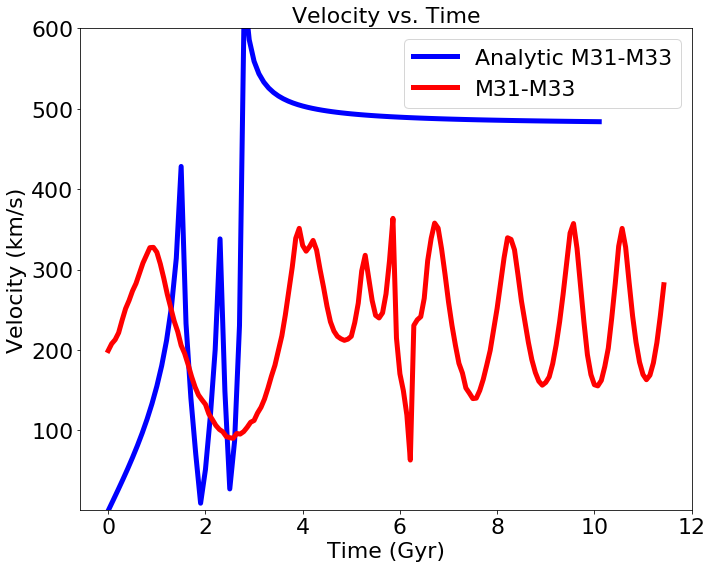

In [10]:
# Plot the orbital velocities of the galaxies 
#################################

fig, ax= plt.subplots(figsize=(10, 8))

# Plot the velocities of M33 and M31
ax.plot(M33_A_Orbit['t'], A_M33_M31_V, 'b', lw=5, label='Analytic M31-M33')

# Plot the velocities of M33 and M31
ax.plot(M31Orbit['t'], M33_M31_V, 'r', lw=5, label='M31-M33')

# Add axis labels
ax.set_xlabel('Time (Gyr)', fontsize=22)
ax.set_ylabel('Velocity (km/s)', fontsize=22)
ax.set_title("Velocity vs. Time", fontsize=22)

#set axis limits
ax.set_ylim([1, 600])

#adjust tick label font size
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# add a legend with some customizations.
legend = ax.legend(loc='upper right',fontsize=22)

# tight layout
fig.tight_layout()

# Save to a file
#fig.savefig('orbit_vel.pdf')